In [ ]:
# !pip install category_encoders==2.*
# !pip install pdpbox
import os
os.getcwd()

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer

In [2]:
filepath = 'hyundi.csv'

def wrangle(filepath):
  df = pd.read_csv(filepath, skipinitialspace=True)
  df.columns = ['model','year','price','transmission','mileage','fuelType','tax','mpg','engineSize']

  # leakagehttp://localhost:8888/notebooks/Data/Hyundai_Price.ipynb#
  # df.drop(columns='tax',inplace=True)

  return df

df = wrangle(filepath)
df.head(3)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7


In [ ]:
# # demystifying the MPG column
# df.mpg.describe()

# df[df.mpg == 1.1]

In [3]:
target='price'
X = df.drop(columns=target)
y = df[target]
# X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.1, random_state=7)

## Linear Regression

In [5]:
# Baseline Accuracy with Mean Absolute Error
y_pred = len(y_train) *[y_train.mean()]
baseline_mae = mean_absolute_error(y_train,y_pred)
print('Baseline MAE: ', baseline_mae)

# fit the model
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                      StandardScaler(),
                      LinearRegression())
model.fit(X_train,y_train);

# Mean Absolute Error Accuracy Score
# Training
trai_acc = mean_absolute_error(y_train,model.predict(X_train))
print('Training MAE: ', trai_acc)


y_pred_val = model.predict(X_test)
# Validation
test_acc = mean_absolute_error(y_test,y_pred_val)
print('Test MAE: ',test_acc)

print('Rsquared Test:', r2_score(y_test,model.predict(X_test)))


Baseline MAE:  4608.204720122586
Training MAE:  1467.8361235272237
Test MAE:  2203542821655.3564
Rsquared Test:

C:\Users\Mayra\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


 -7.270503586034585e+19


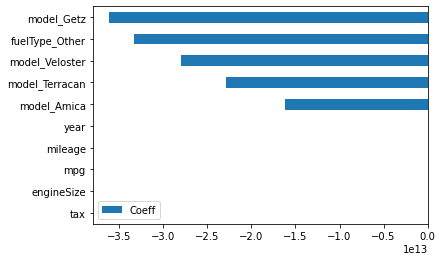

In [20]:
model_lr_coef = model.named_steps['linearregression'].coef_
model_features = model.named_steps['onehotencoder'].get_feature_names()

model_lr_info = pd.DataFrame(data=model_lr_coef,
                             index=model_features, 
                             columns=['Coeff']).sort_values(by='Coeff',
                                                            key=abs).head(10)
model_lr_info.plot(kind='barh');
# plt.sh

## Random Forest Regression

In [9]:
model_rf = make_pipeline(OneHotEncoder(),
                         RandomForestRegressor(random_state=7,
                                n_estimators=65,
                                max_leaf_nodes=270,
                                max_depth=70))
model_rf.fit(X_train,y_train);

C:\Users\Mayra\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [12]:
# Mean Absolute Error Accuracy Score
# Training
print('Random Forest Regressor')

print('Baseline MAE: ', baseline_mae)

training_acc = mean_absolute_error(y_train,model_rf.predict(X_train))
print('MAE Train: ', training_acc)

# Validation
test_acc = mean_absolute_error(y_test,model_rf.predict(X_test))
print('MAE Test: ',test_acc)

print('Rsquared Test:', r2_score(y_test,model_rf.predict(X_test)))


Random Forest Regressor
Baseline MAE:  4608.204720122586
MAE Train:  622.3238134761249
MAE Test:  767.76308141557
Rsquared Test: 0.9642028247465217


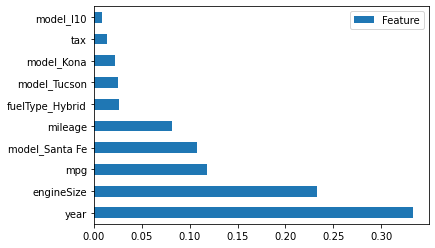

In [18]:
model_rf_coef = model_rf.named_steps['randomforestregressor'].feature_importances_
model_rf_info = pd.DataFrame(data=model_rf_coef, 
                             index=model_features,
                             columns=['Feature']).sort_values(by='Feature',
                                                           ascending=False,
                                                             key=abs).head(10)
model_rf_info.plot(kind='barh');
# plt.sh

## Tunning the Random Forest Regressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators': range(50,70,1),       
              'max_depth': range(50,75,1),
              'max_leaf_nodes': range(260,280,1)}

#  'randomforestclassifier__learning_rate': range(225,230,1),
#               'randomforestclassifier__max_leaf_nodes': range(610,620,5)

model_rscv = RandomizedSearchCV(model_rf,
                                param_distributions=param_grid,
                                n_iter=10,
                                cv=None,
                                n_jobs=-1,
                                verbose=1)


model_rscv.fit(X_train, y_train)


In [ ]:
model_rscv.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': range(50,70,5),       
              'max_depth': range(50,75,5),
              'max_leaf_nodes': range(260,280,10)}

#  'randomforestclassifier__learning_rate': range(225,230,1),
#               'randomforestclassifier__max_leaf_nodes': range(610,620,5)

model_gscv = GridSearchCV(model_rf,
                                param_grid=param_grid,
                                cv=None,
                                n_jobs=-1,
                                verbose=1)


model_gscv.fit(X_train, y_train)


In [ ]:
model_gscv.best_params_

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

feature = 'mileage'

isolate = pdp_isolate(
    model_rf,
    dataset = X_test,
    model_features = X_test.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

In [ ]:
features = ['mpg', 'year']

interact = pdp_interact(
    model_rf,
    dataset = X_test,
    model_features = X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);